# Group Case Study: Hand Gesture Recognition Project

# 1. Importing all the important libraries

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Importing the python basic libraries and functions

import numpy as np
import os
import datetime

# Importing additional libraries which will be needed for image pre-processing

import cv2
import imageio as imio
from PIL import Image

In [3]:
# Ignoring the warnings

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)

from keras import backend as K
tf.random.set_seed(30)

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
from keras.layers import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers import GRU
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers import LSTM

# 2. Vizualising Sample Data

In [6]:
# Creating variable for the path of the source directory

source_directory_path = r"K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\"

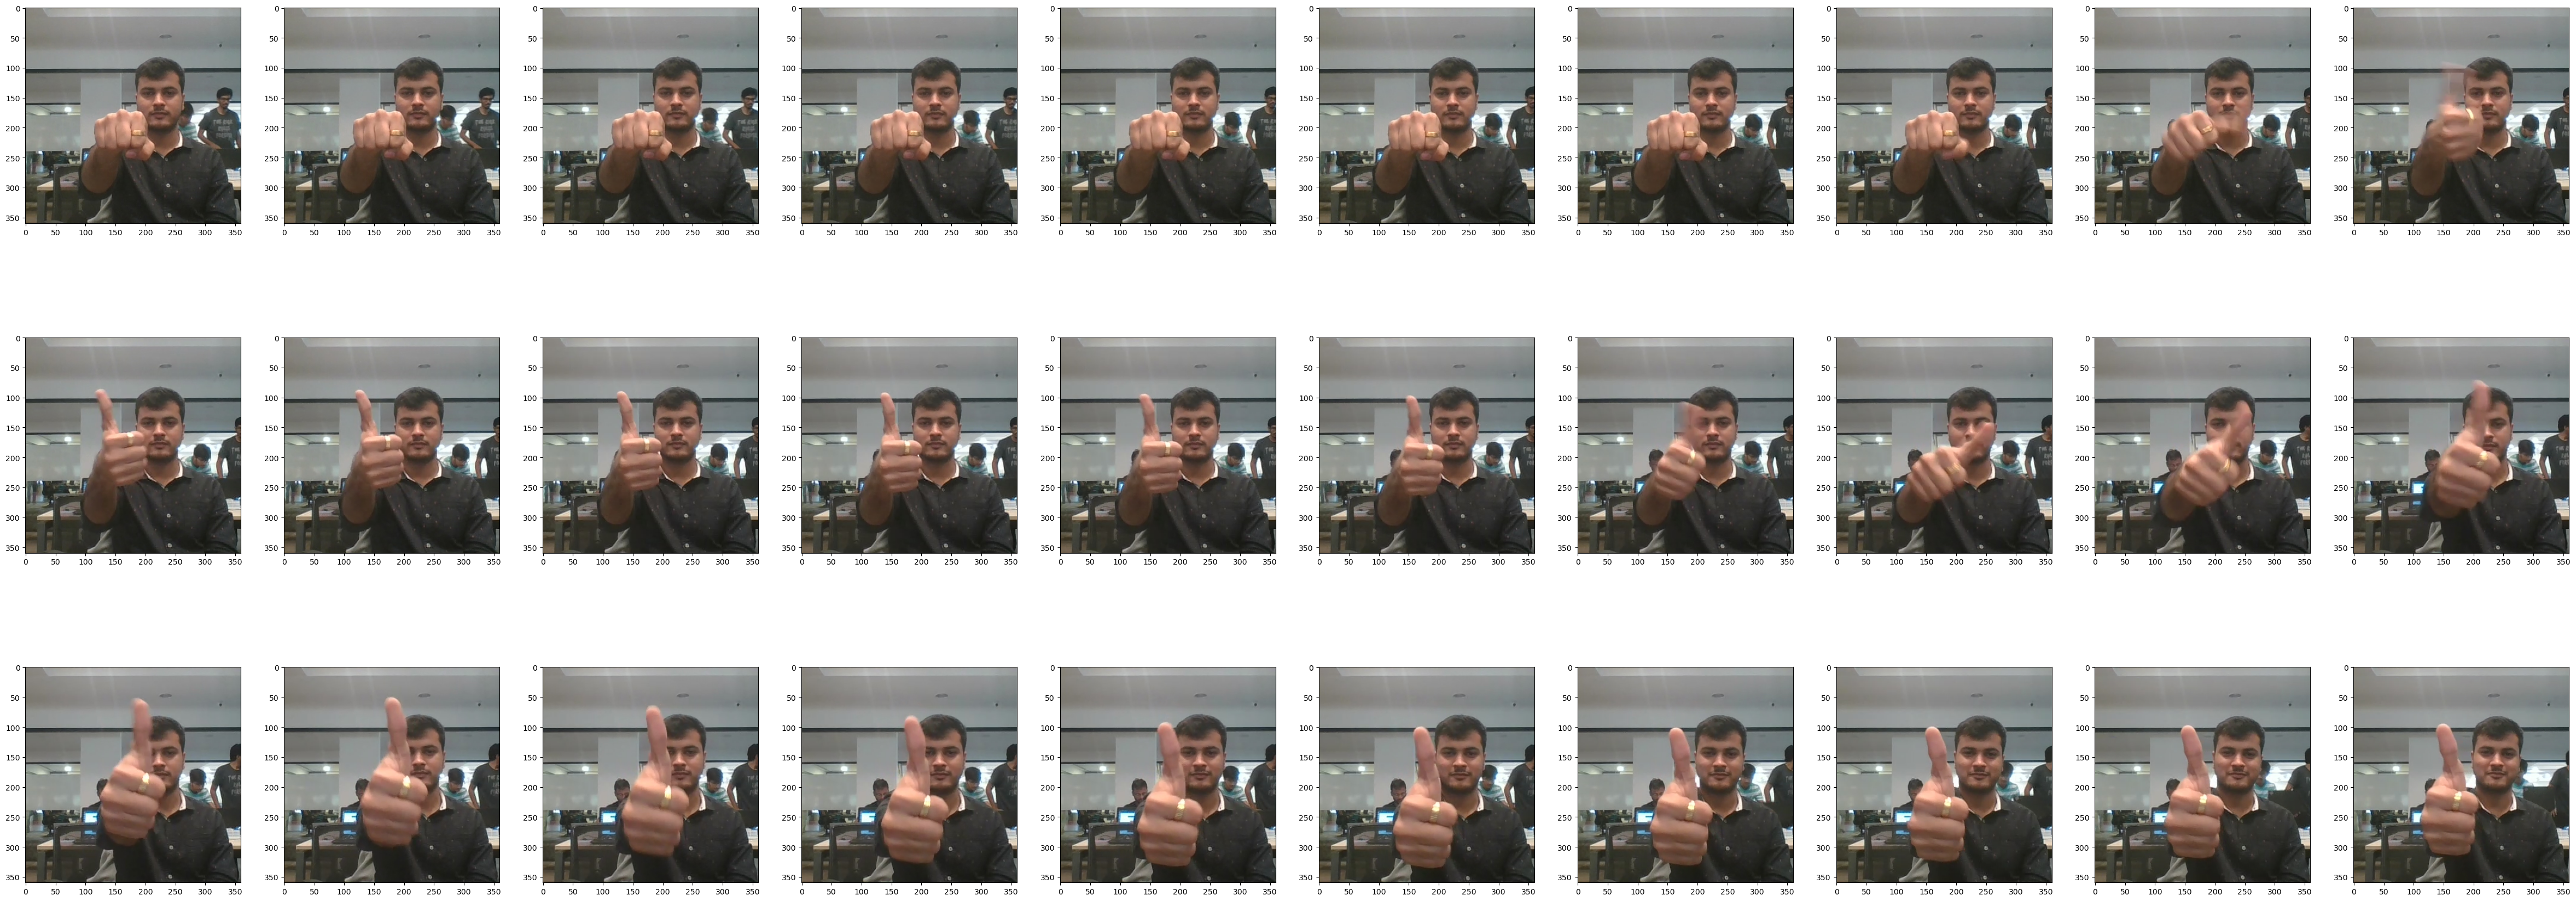

In [7]:
# Vizualising the pictures present in the "Thumbs Up" folder

images = []
for img_path in glob.glob(source_directory_path+'Sample Data\\WIN_20180907_15_39_54_Pro_Thumbs Up_new\\*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(60,30))
columns = 10
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [8]:
# This prevents that resource exhausted error assuming you're batch size is within reason.

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

#Now when creating your session pass this config to it.
sess =  tf.compat.v1.Session(config=config)

In [9]:
train_doc = np.random.permutation(open(source_directory_path+'train.csv').readlines())
val_doc = np.random.permutation(open(source_directory_path+'val.csv').readlines())

# Experiment with the batch size
batch_size = 25

In [10]:
# Making a User-Defined function that allows us to crop an image

def crop_image(image, scale=1.0):
    center_x, center_y = image.shape[1] / 2, image.shape[0] / 2
    width_scaled, height_scaled = image.shape[1] * scale, image.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    cropped_image = image[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return cropped_image

# 3. Defining the first "Generator" function

In [11]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    
    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,64,64,3))
            # Batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # Iterate over the batch_size    
            for folder in range(batch_size): 
                # Read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                #  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Crop the images and resize them. Note that the images are of 2 different shape 
# And the conv3D will throw error if the inputs in a batch have different shapes

                    # Cropping image by 10 % of original size :
                    image = crop_image(image, 0.10)
    
                    # Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            # You yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image by 10 % of original size :
                    image = crop_image(image, 0.10)

                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Performing normalization on the images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [12]:
# Making a User-Defined function that plots graphs of "Model Accuracy" and "Plot Loss" for each epoch


def plot_results(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axs[0].plot(range(1, len(history.history['categorical_accuracy']) + 1), history.history['categorical_accuracy'])
    axs[0].plot(range(1, len(history.history['val_categorical_accuracy']) + 1), history.history['val_categorical_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    axs[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [13]:
# Initialising the values of the required variables

curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


# 4. Model Building

### Preparing Model 1:  Conv 3D Model

- Epochs: 5
- Batch Size: 25
- Input Images Size: 64x64

In [14]:
# Building the first model which is 3D Conv model:

modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

# Code for our optimizer function

optimiser = optimizers.legacy.Adam(lr=0.0002, decay=1e-6)

# compile model
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Printing the model summary
print (modelConv3D_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 64, 64, 8)     656       
                                                                 
 activation (Activation)     (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization (Batch  (None, 18, 64, 64, 8)     32        
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 9, 32, 32, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_1 (Activation)   (None, 9, 32, 32, 16)     0

C:\Users\heyit\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
# This is for first 3D Conv model: (modelConv3D_1)

history = modelConv3D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_11860\192403864.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 25
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 2.1004 - categorical_accuracy: 0.2670Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 25

Epoch 1: saving model to model_init_2024-04-3002_46_44.712588\model-00001-2.10035-0.26697-1.60319-0.22000.h5
27/27 [==============================] - 49s 2s/step - loss: 2.1004 - categorical_accuracy: 0.2670 - val_loss: 1.6032 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/5


C:\Users\heyit\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.6735 - categorical_accuracy: 0.3816
Epoch 2: saving model to model_init_2024-04-3002_46_44.712588\model-00002-1.67355-0.38160-1.66436-0.20000.h5
27/27 [==============================] - 33s 1s/step - loss: 1.6735 - categorical_accuracy: 0.3816 - val_loss: 1.6644 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.5498 - categorical_accuracy: 0.4072
Epoch 3: saving model to model_init_2024-04-3002_46_44.712588\model-00003-1.54979-0.40724-1.65710-0.24000.h5
27/27 [==============================] - 33s 1s/step - loss: 1.5498 - categorical_accuracy: 0.4072 - val_loss: 1.6571 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 4/5
27/27 [==============================] - ETA: 0s - loss: 1.4316 - categorical_accuracy: 0.4480
Epoch 4: saving model to model_init_2024-04-3002_46_44.712588\model-00004-1.43157-0.44796-1.76372-0.23000.h5

Epoch 4: ReduceLROnPlateau 

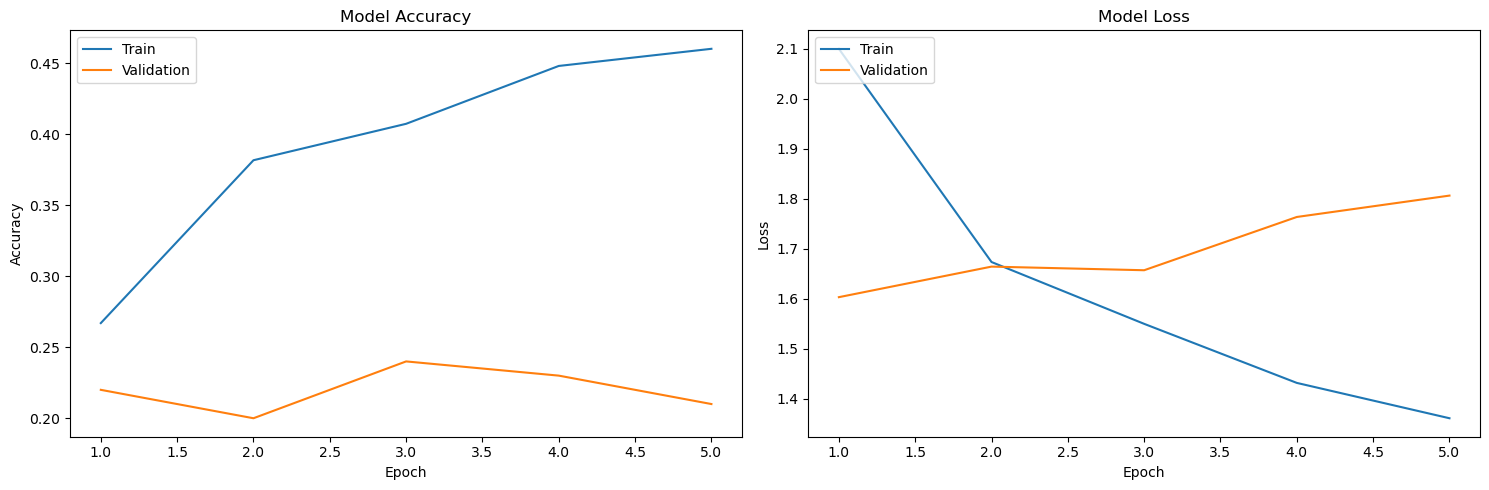

In [20]:
# Plotting graph to check the accuracy of the first 3D Conv model: (modelConv3D_1)

plot_results(history)

**Inference**:
In our base model "modelConv3D_1", we've obtained a training accuracy of 44% and a validation accuracy of 23%.

### Preparing Second Model  : Conv 3D Model

- Epochs: 20
- Batch Size: 30
- Input Images Size: 64x64

No dropouts in the convolutional layer, utilizing batch normalization. Input images sized 64x64, Adam optimizer with fixed LR of 0.0002, no decay. 18 out of 30 images used as input. Increased dropout from 0.25 to 0.50 in the first dense layer.

In [21]:
batch_size = 30
num_epochs = 20

In [22]:
# Building the second model which is 3D Conv model:

modelConv3D_2 = Sequential()

modelConv3D_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Dense(5, activation='softmax'))

# Optimizer Code
optimiser = optimizers.Adam(lr=0.0002)

# Compiling the Model
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_6 (Bat  (None, 18, 64, 64, 8)     32        
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 9, 32, 32, 8)      0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_5 (Activation)   (None, 9, 32, 32, 16)    

In [23]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# REducelronplateau code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
# This is for second 3D Conv model: (modelConv3D_2)

history = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\3922977511.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.1241 - categorical_accuracy: 0.2353Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 30

Epoch 1: saving model to model_init_2024-04-2816_54_08.250825\model-00001-2.12406-0.23529-1.62585-0.22000.h5
23/23 [==============================] - 38s 2s/step - loss: 2.1241 - categorical_accuracy: 0.2353 - val_loss: 1.6259 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.8261 - categorical_accuracy: 0.2956
Epoch 2: saving model to model_init_2024-04-2816_54_08.250825\model-00002-1.82607-0.29563-1.66295-0.21000.h5
23/23 [==============================] - 36s 2s/step - loss: 1.8261 - categorical_accuracy: 0.2956 - val_loss: 1.6630 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
23/23 [======================

In [26]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


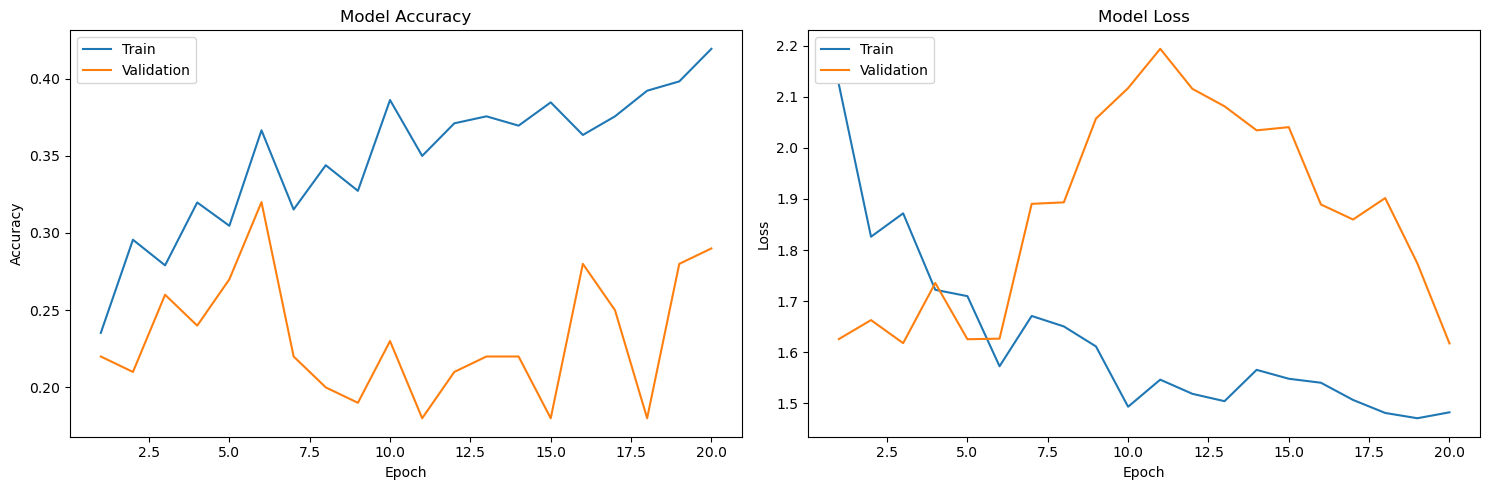

In [30]:
# Plotting graph to check the accuracy of the second 3D Conv model: (modelConv3D_2)

plot_results(history)

**Inference:**
The "modelConv3D_2" model achieved its highest validation accuracy of 32%.

### Preparing Third Model  : Conv 3D Model

- Epochs: 20
- Batch Size: 30
- Input images size: 84x84
- Image Cropping: 3%


No dropout in Conv layer, with batch normalization. Adam optimizer, LR 0.0002, no decay. 18 out of 30 images used as input. Reverted dropout from 0.50 to 0.25 in 1st dense layer.

In [40]:
# Modified generator function :

def generator_third_model(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,84,84,3))
            # Batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # Iterate over the batch_size    
            for folder in range(batch_size): 
                # read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                #  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

                    # Cropping image by 3 % of original size :
                    image = crop_image(image, 0.03)
    
                    # Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image by 3 % of original size :
                    image = crop_image(image, 0.03)

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [41]:
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [42]:
# Building the model which is 3D Conv model:

modelConv3D_3 = Sequential()

modelConv3D_3.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,84,84,3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Flatten())

modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(5, activation='softmax'))

# Optimizer Code
optimiser = optimizers.Adam(lr=0.0002)

# Compiling the Model
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 84, 84, 8)     656       
                                                                 
 activation_12 (Activation)  (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_18 (Ba  (None, 18, 84, 84, 8)     32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 9, 42, 42, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_13 (Activation)  (None, 9, 42, 42, 16)    

In [43]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 288101


In [44]:
train_generator = generator_third_model(train_path, train_doc, batch_size)
val_generator = generator_third_model(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [45]:
# This is for third 3D Conv model: (modelConv3D_3)

history = modelConv3D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\1084156625.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.0398 - categorical_accuracy: 0.3137Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 30

Epoch 1: saving model to model_init_2024-04-2817_43_50.468882\model-00001-2.03978-0.31373-1.60418-0.20000.h5
23/23 [==============================] - 45s 2s/step - loss: 2.0398 - categorical_accuracy: 0.3137 - val_loss: 1.6042 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.7607 - categorical_accuracy: 0.3363
Epoch 2: saving model to model_init_2024-04-2817_43_50.468882\model-00002-1.76068-0.33635-1.73248-0.20000.h5
23/23 [==============================] - 38s 2s/step - loss: 1.7607 - categorical_accuracy: 0.3363 - val_loss: 1.7325 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
23/23 [======================

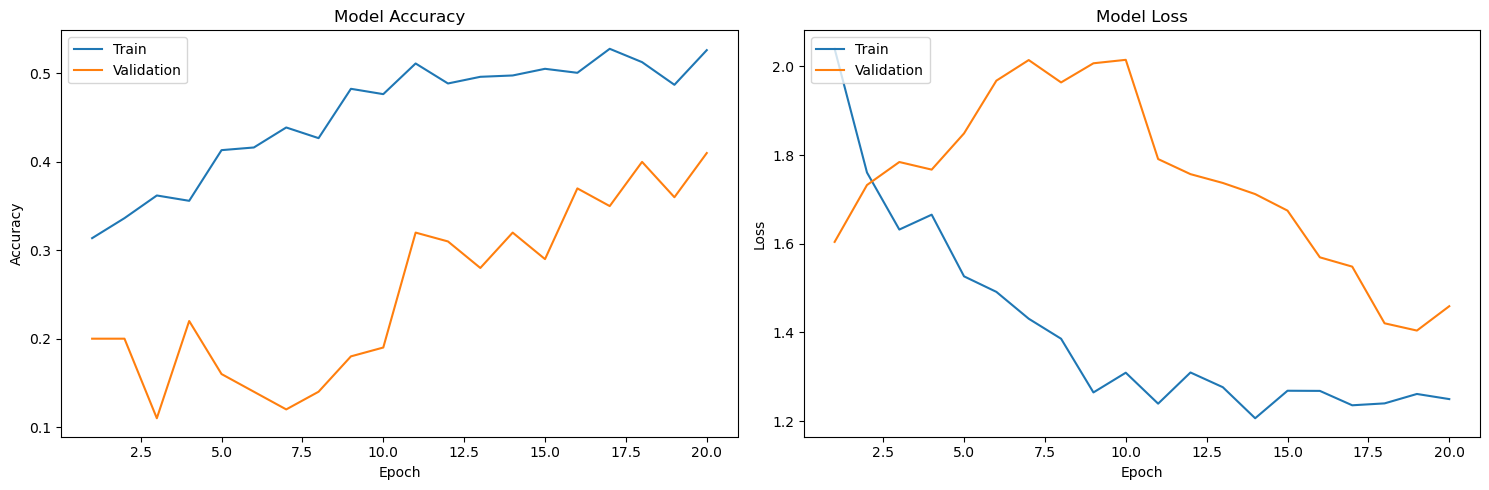

In [46]:
# Plotting graph to check the accuracy of the third 3D Conv model: (modelConv3D_3)

plot_results(history)

**Inference:**
The "modelConv3D_3" model achieved its highest validation accuracy of 41%.

### Preparing Fourth Model : Conv 3D model 

- Epochs: 30
- Batch Size: 50
- Input images size: 100x100

In [47]:
train_doc = np.random.permutation(open(source_directory_path+'train.csv').readlines())
val_doc = np.random.permutation(open(source_directory_path+'val.csv').readlines())

In [48]:
def generator_fourth_model(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,100,100,3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # iterate over the batch_size    
            for folder in range(batch_size): 
                # read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                #  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

                    # Cropping image by 10 % of original size :
                    image = crop_image(image, 0.02)
    
                    # Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            # You yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
        # Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image by 10 % of original size :
                    image = crop_image(image, 0.02)

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [50]:
modelConv3D_4 = Sequential()

modelConv3D_4.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=(18,100,100,3),
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(32, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(64, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
modelConv3D_4.add(Flatten())

modelConv3D_4.add(Dense(256, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(128, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

#softmax layer
modelConv3D_4.add(Dense(5, activation='softmax'))

# Optimizer Code
optimiser = Adam()

# Compiling the Model
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_27 (Ba  (None, 18, 100, 100, 8)   32        
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 9, 50, 50, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_28 (Ba  (None, 9, 50, 50, 16)    

In [51]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 651109


In [52]:
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 50
num_epochs = 30

train_generator = generator_fourth_model(train_path, train_doc, batch_size)
val_generator = generator_fourth_model(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [53]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [54]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
# This is for fourth 3D Conv model: (modelConv3D_4)

history = modelConv3D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\232595776.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.9911 - categorical_accuracy: 0.2278Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 50

Epoch 1: saving model to model_init_2024-04-2818_43_12.568811\model-00001-1.99111-0.22775-1.60809-0.18000.h5
14/14 [==============================] - 37s 3s/step - loss: 1.9911 - categorical_accuracy: 0.2278 - val_loss: 1.6081 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5474 - categorical_accuracy: 0.2971
Epoch 2: saving model to model_init_2024-04-2818_43_12.568811\model-00002-1.54744-0.29713-1.61015-0.20000.h5
14/14 [==============================] - 31s 2s/step - loss: 1.5474 - categorical_accuracy: 0.2971 - val_loss: 1.6102 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
14/14 [======================

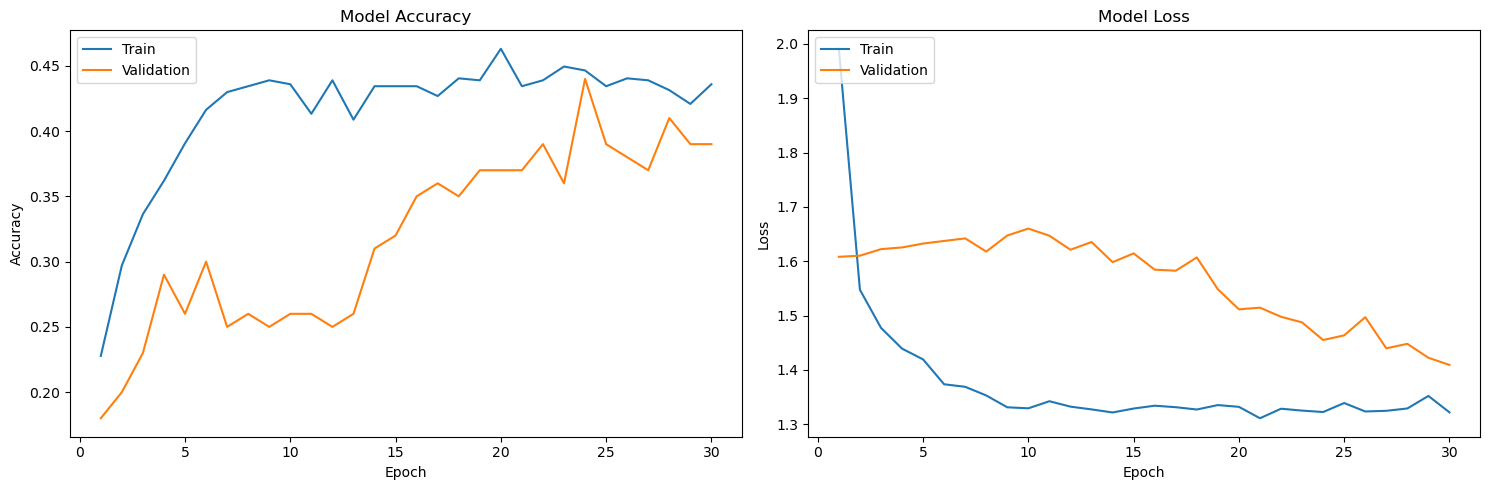

In [56]:
# Plotting graph to check the accuracy of the fourth 3D Conv model: (modelConv3D_4)

plot_results(history)

**Inference:**
The "modelConv3D_4" model achieved its highest validation accuracy of 44%.

### Preparing Model 5 : Conv 3D model

- Epochs: 30
- Batch Size: 30
- Input Images Size: 84x84

In [57]:
batch_size = 30

In [58]:
def generator_fifth_model(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)] 
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,84,84,3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # Iterate over the batch_size    
            for folder in range(batch_size): 
                # Read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                # Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
        # Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [59]:
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [60]:
modelConv3D_5 = Sequential()

modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

# Optimizer Code
optimiser = optimizers.Adam(lr=0.0002)

# Compiling the Model
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_5.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_24 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_30 (Ba  (None, 30, 84, 84, 8)     32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 15, 42, 42, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_25 (Activation)  (None, 15, 42, 42, 16)   

In [61]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [62]:
train_generator = generator_fifth_model(train_path, train_doc, batch_size)
val_generator = generator_fifth_model(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [63]:
# This is for fifth 3D Conv model: (modelConv3D_5)

history = modelConv3D_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\1349798654.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.7824 - categorical_accuracy: 0.3560Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 30

Epoch 1: saving model to model_init_2024-04-2819_01_35.787529\model-00001-1.78240-0.35596-1.59549-0.21000.h5
23/23 [==============================] - 78s 3s/step - loss: 1.7824 - categorical_accuracy: 0.3560 - val_loss: 1.5955 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2167 - categorical_accuracy: 0.5279
Epoch 2: saving model to model_init_2024-04-2819_01_35.787529\model-00002-1.21670-0.52790-1.69375-0.17000.h5
23/23 [==============================] - 52s 2s/step - loss: 1.2167 - categorical_accuracy: 0.5279 - val_loss: 1.6938 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
23/23 [======================

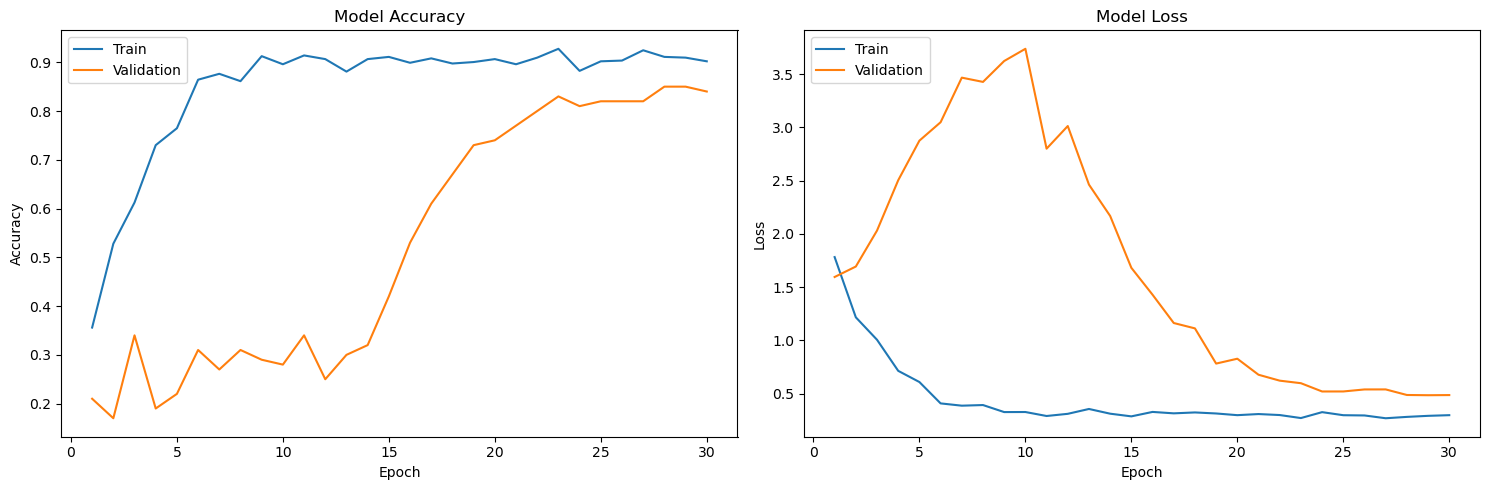

In [64]:
# Plotting graph to check the accuracy of the fifth 3D Conv model: (modelConv3D_5)

plot_results(history)

**Inference:**
The "modelConv3D_5" model achieved its highest test accuracy of 91% and validation accuracy of 85%.

 _After conducting several experiments with the Conv3D model, we found that the performance did not meet our expectations. Therefore, let's explore alternative models for addressing the same problem statement._

### Preparing Model 6 : CNN - LSTM Model (I)

- Epochs: 20
- Input Images Size: 120x120

In [65]:
# Input
input_shape=(30,120,120,3)

In [66]:
#write your model here
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(128))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(128,activation='relu'))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(5, activation='softmax'))


# Optimizer Code
optimiser = optimizers.Adam()

# Compiling the Model
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_1.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 60, 60, 32)   

In [67]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [68]:
def generator_for_LSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]

    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,120,120,3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # Iterate over the batch_size    
            for folder in range(batch_size): 
                # Read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                # Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [69]:
train_generator = generator_for_LSTM(train_path, train_doc, batch_size)
val_generator = generator_for_LSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:
# This is for sixth model: (CNNlstm_1)

history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\2841256302.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3536 - categorical_accuracy: 0.4253Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 20

Epoch 1: saving model to model_init_2024-04-2819_34_32.539305\model-00001-1.35358-0.42534-1.73315-0.18000.h5
34/34 [==============================] - 93s 3s/step - loss: 1.3536 - categorical_accuracy: 0.4253 - val_loss: 1.7331 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1435 - categorical_accuracy: 0.5324
Epoch 2: saving model to model_init_2024-04-2819_34_32.539305\model-00002-1.14347-0.53243-1.88525-0.30000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.1435 - categorical_accuracy: 0.5324 - val_loss: 1.8853 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
34/34 [======================

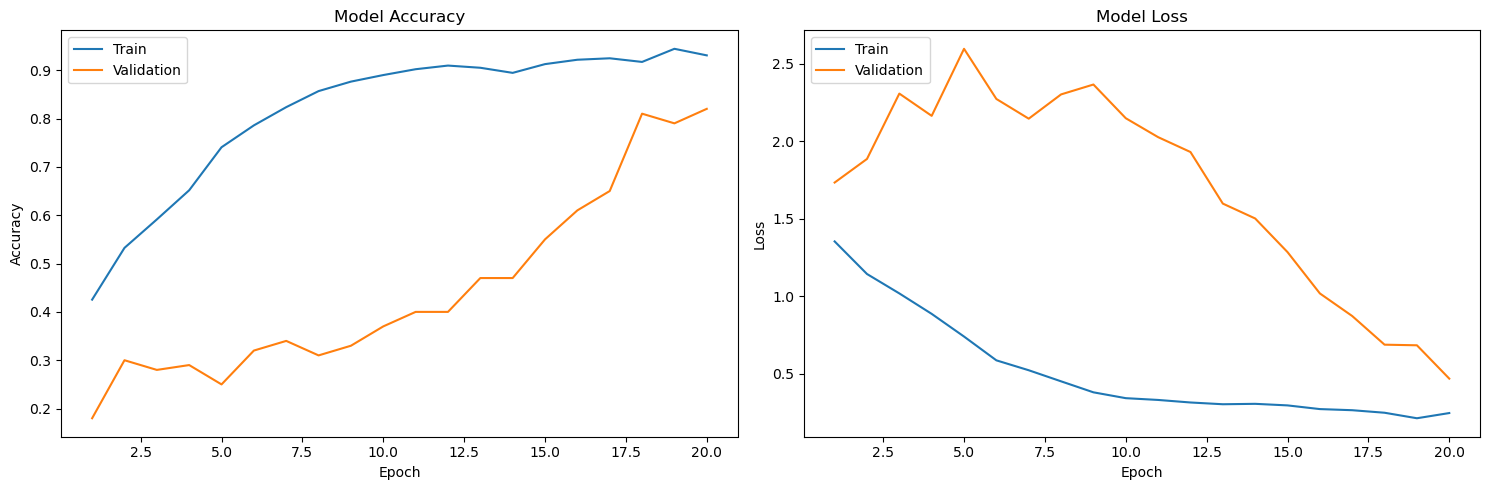

In [71]:
# Plotting graph to check the accuracy of the sixth model: (CNNlstm_1)

plot_results(history)

**Inference:**
The "CNNlstm_1" model achieved its highest test accuracy of 93% and validation accuracy of 82% by the CNN-LSTM (Model 1).

### Preparing Model 7 : CNN - LSTM Model (II)

- Epochs: 20
- Batch Size: 20
- Input Images Size: 160x160

In [72]:
# Input
input_shape=(30,160,160,3)


#write your model here
CNNlstm_2 = Sequential()

CNNlstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Flatten()))


CNNlstm_2.add(LSTM(128))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(128,activation='relu'))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(5, activation='softmax'))


# Optimizer Code
optimiser = optimizers.Adam()

# Compiling the Model
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_2.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, 30, 160, 160, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_17 (TimeD  (None, 30, 160, 160, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_18 (TimeD  (None, 30, 80, 80, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 30, 80, 80, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 30, 80, 80, 32)   

In [73]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 3754597


In [74]:
def generator_for_secondLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,160,160,3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # Iterate over the batch_size    
            for folder in range(batch_size): 
                # Read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                #  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,160,160,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [75]:
train_generator = generator_for_secondLSTM(train_path, train_doc, batch_size)
val_generator = generator_for_secondLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [76]:
# This is for seventh model: (CNNlstm_2)

history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\1681903267.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4586 - categorical_accuracy: 0.3831Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 20

Epoch 1: saving model to model_init_2024-04-2819_34_32.539305\model-00001-1.45862-0.38311-1.61973-0.26000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.4586 - categorical_accuracy: 0.3831 - val_loss: 1.6197 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0951 - categorical_accuracy: 0.5913
Epoch 2: saving model to model_init_2024-04-2819_34_32.539305\model-00002-1.09509-0.59125-2.27302-0.30000.h5
34/34 [==============================] - 153s 5s/step - loss: 1.0951 - categorical_accuracy: 0.5913 - val_loss: 2.2730 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
34/34 [====================

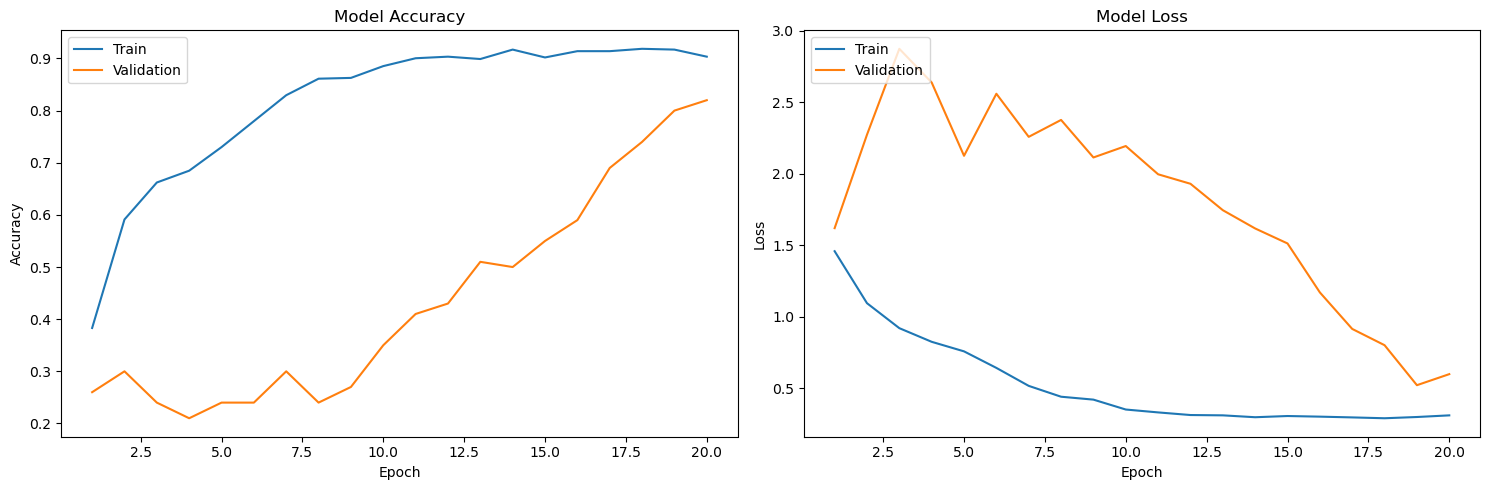

In [77]:
# Plotting graph to check the accuracy of the seventh model: (CNNlstm_2)

plot_results(history)

**Inference:**
The "CNNlstm_2" model achieved its highest test accuracy of 90% and validation accuracy of 82% by the CNN-LSTM (Model 2).

### Preparing Model 8 : CNN - LSTM Model (III)

- Epochs: 20
- Input Images Size: 120x120

In [78]:
input_shape=(30,120,120,3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_3.add(Flatten())
CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))

CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))


CNNlstm_3.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_3.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_28 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_46 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_29 (Conv3D)          (None, 30, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_29 (Activation)  (None, 30, 120, 120, 16  

In [79]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 1287989


In [80]:
train_generator = generator_for_LSTM(train_path, train_doc, batch_size)
val_generator = generator_for_LSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [81]:
# This is for eight model: (CNNlstm_3)

history = CNNlstm_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\2924125861.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5510 - categorical_accuracy: 0.4087Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 20

Epoch 1: saving model to model_init_2024-04-2819_34_32.539305\model-00001-1.55096-0.40875-1.97305-0.26000.h5
34/34 [==============================] - 186s 5s/step - loss: 1.5510 - categorical_accuracy: 0.4087 - val_loss: 1.9730 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2665 - categorical_accuracy: 0.4932
Epoch 2: saving model to model_init_2024-04-2819_34_32.539305\model-00002-1.26652-0.49321-2.84981-0.21000.h5
34/34 [==============================] - 182s 5s/step - loss: 1.2665 - categorical_accuracy: 0.4932 - val_loss: 2.8498 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [====================

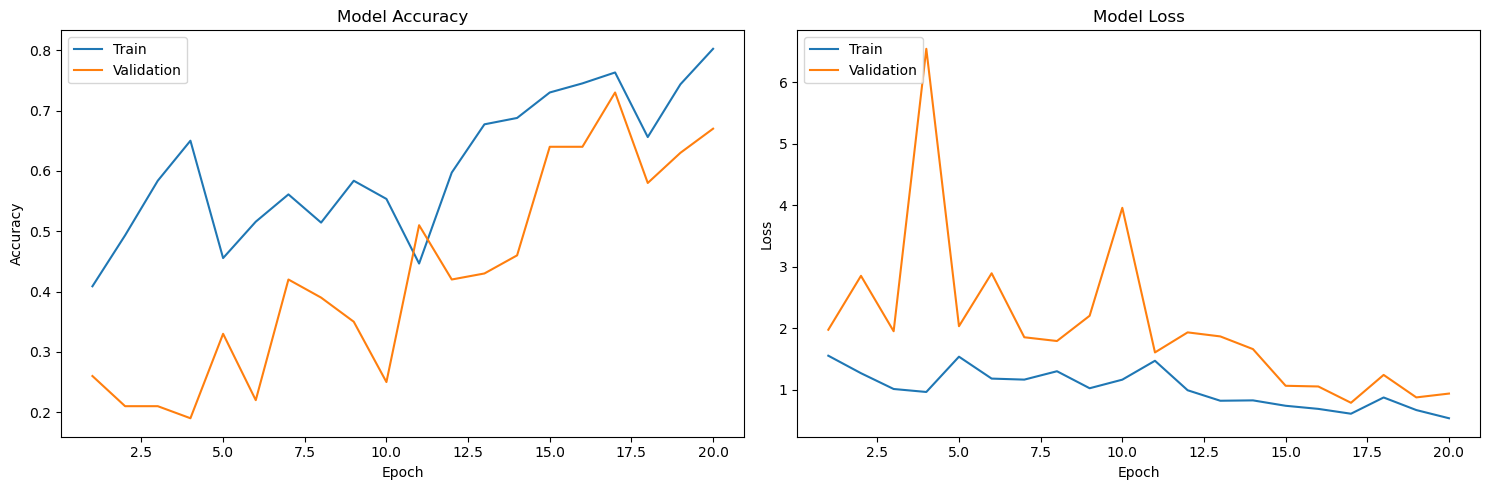

In [82]:
# Plotting graph to check the accuracy of the eight model: (CNNlstm_3)

plot_results(history)

**Inference:**
The "CNNlstm_3" model achieved its highest highest test accuracy of 76% and validation accuracy of 73% by the CNN-LSTM (Model 3).

### Preparing Model 9 : CNN LSTM With GRU

- Epochs: 20
- Input Images Size: 120x120

In [83]:
input_shape=(30,120,120,3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeD  (None, 30, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_33 (TimeD  (None, 30, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_34 (TimeD  (None, 30, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_35 (TimeD  (None, 30, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 30, 60, 60, 32)  

In [84]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 2573925


In [85]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [86]:
train_generator = generator_for_LSTM(train_path, train_doc, batch_size)
val_generator = generator_for_LSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [87]:
# This is for ninth model: (GRU_lstm)

history = GRU_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\3372521268.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = GRU_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4782 - categorical_accuracy: 0.3484Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 20

Epoch 1: saving model to model_init_2024-04-2901_15_30.930435\model-00001-1.47818-0.34842-1.89891-0.23000.h5
34/34 [==============================] - 126s 4s/step - loss: 1.4782 - categorical_accuracy: 0.3484 - val_loss: 1.8989 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0769 - categorical_accuracy: 0.5581
Epoch 2: saving model to model_init_2024-04-2901_15_30.930435\model-00002-1.07690-0.55807-1.64175-0.23000.h5
34/34 [==============================] - 115s 3s/step - loss: 1.0769 - categorical_accuracy: 0.5581 - val_loss: 1.6417 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [====================

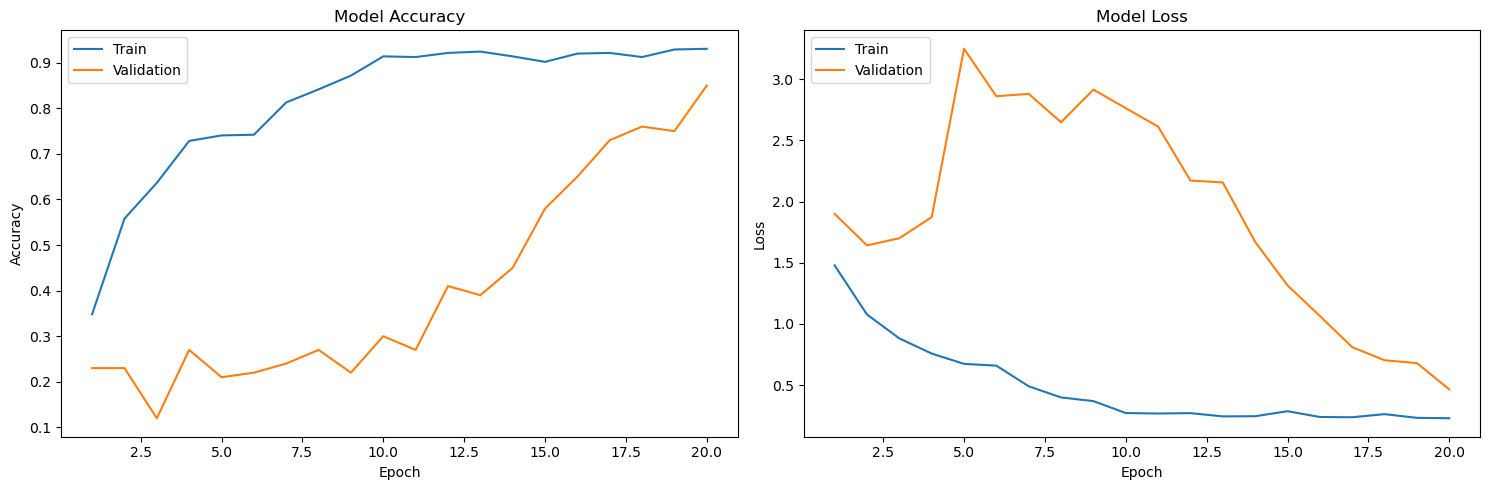

In [88]:
# Plotting graph to check the accuracy of the ninth model: (GRU_lstm)

plot_results(history)

**Inference:**
The "GRU_lstm" model achieved its highest test accuracy of 93% and validation accuracy of 85% by the CNN-LSTM (With GRU).

### Utilizing Pre-trained Models for Transfer Learning

### Preparing Model 10: Model with Transfer Learning

- Epochs: 20
- Input Images Size: 120x120

In [89]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 3s 0us/step


In [91]:
# Building the model :

input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeD  (None, 18, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, 18, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_47 (TimeD  (None, 18, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, 18, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [92]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [93]:
def generator_for_MobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]

    
    while True:
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        # We iterate over the number of batches
        for batch in range(num_batches): 
            
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # Iterate over the batch_size    
            for folder in range(batch_size): 
                # read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                #  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
                    # Normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            # You yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# Code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [94]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [95]:
train_generator = generator_for_MobileNet(train_path, train_doc, batch_size)
val_generator = generator_for_MobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [96]:
# This is for tenth model: (mobileNetModel)

history = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\1012462639.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2231 - categorical_accuracy: 0.4902Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 5

Epoch 1: saving model to model_init_2024-04-2902_13_19.426448\model-00001-1.22309-0.49020-0.75870-0.72000.h5
133/133 [==============================] - 79s 557ms/step - loss: 1.2231 - categorical_accuracy: 0.4902 - val_loss: 0.7587 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6448 - categorical_accuracy: 0.7511
Epoch 2: saving model to model_init_2024-04-2902_13_19.426448\model-00002-0.64482-0.75113-0.55625-0.79000.h5
133/133 [==============================] - 69s 522ms/step - loss: 0.6448 - categorical_accuracy: 0.7511 - val_loss: 0.5562 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 3/20
133/133 [========

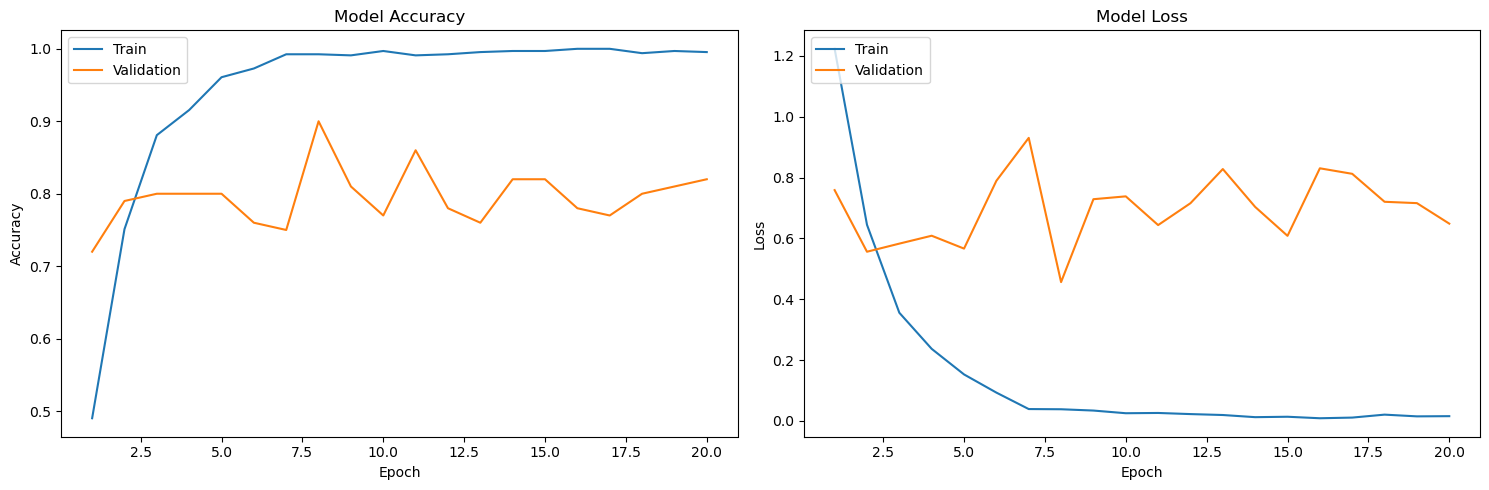

In [97]:
# Plotting graph to check the accuracy of the tenth model: (mobileNetModel)

plot_results(history)

**Inference:**

- The "mobileNetModel" model achieved its highest test accuracy of 99% and validation accuracy of 90% by MobileNet model.
- Currently, we're not training the MobileNet weights, and although the validation accuracy is really good, there's evidence of slight overfitting. Let's proceed by training the MobileNet weights as well and observe if this leads to any performance improvement."

### Preparing Model 11: Transfer Learning With GRU and Training all Weights

- Epochs: 20
- Input Images Size: 120x120
- Training all Weights

In [98]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (mobileNetModel.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeD  (None, 18, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, 18, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_47 (TimeD  (None, 18, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, 18, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [99]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [100]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = source_directory_path+'train'
val_path = source_directory_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [101]:
train_generator = generator_for_MobileNet(train_path, train_doc, batch_size)
val_generator = generator_for_MobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Reducelronplateau Code
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [102]:
# This is for eleventh model: (mobileNetModelWeight)

history = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\heyit\AppData\Local\Temp\ipykernel_18216\4064748165.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.0088 - categorical_accuracy: 0.6033Source path =  K:\\Assignment\\Gesture Recognition\\Datasets\\Project_data\\val ; batch size = 5

Epoch 1: saving model to model_init_2024-04-2902_49_52.990744\model-00001-1.00877-0.60332-0.59907-0.74000.h5
133/133 [==============================] - 239s 2s/step - loss: 1.0088 - categorical_accuracy: 0.6033 - val_loss: 0.5991 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.4822 - categorical_accuracy: 0.8627
Epoch 2: saving model to model_init_2024-04-2902_49_52.990744\model-00002-0.48221-0.86275-0.37458-0.87000.h5
133/133 [==============================] - 229s 2s/step - loss: 0.4822 - categorical_accuracy: 0.8627 - val_loss: 0.3746 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 3/20
133/133 [============

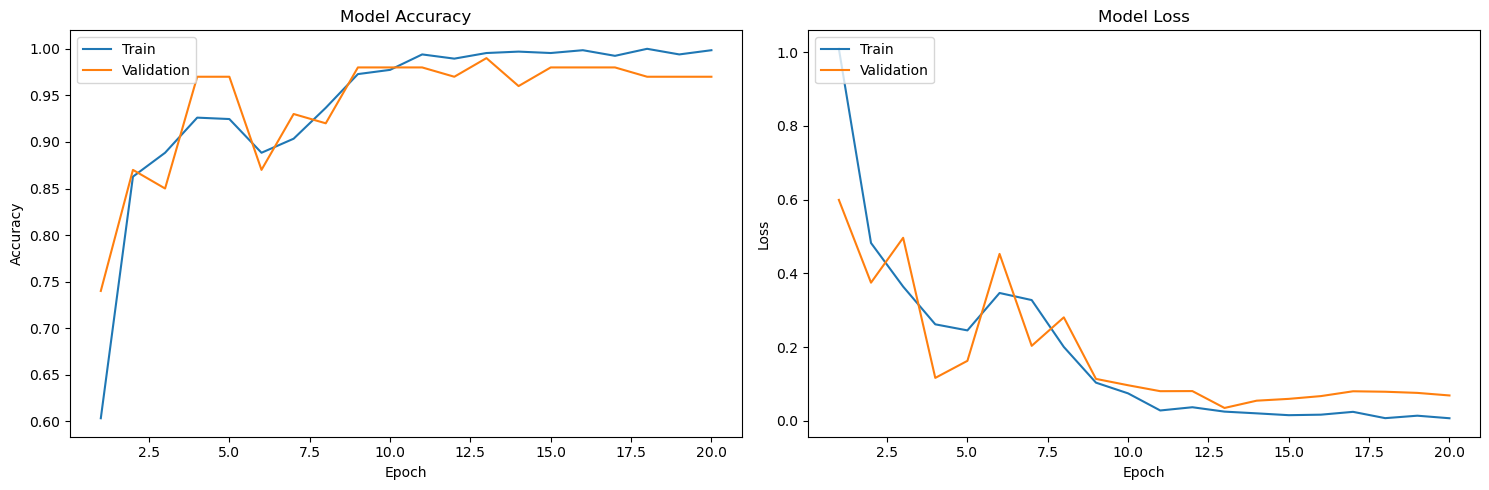

In [103]:
# Plotting graph to check the accuracy of the eleventh model: (mobileNetModelWeight)

plot_results(history)

**Inference**:
Using transfer learning with GRU and training all weights, the "mobileNetModelWeight" model achieved its peak train accuracy of 99% and a validation accuracy of 99%.